In [3]:
import os, glob
import sys
import copy 
import pydicom
import random
import re
import scipy
import scipy.misc
import numpy as np
import cv2
import imageio
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
import tensorflow as tf
from tensorflow import keras
from scipy.ndimage import rotate
plt.set_cmap('gray')
%matplotlib inline
## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed


IMG_DTYPE = np.float
SEG_DTYPE = np.uint8


In [2]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [48]:
masks_path = os.path.join('train','masks')
training_path = os.path.join('train','patients')



done


In [139]:
def histeq(im,nbr_bins=256):

   #get image histogram
   imhist,bins = np.histogram(im.flatten(),nbr_bins)
   cdf = imhist.cumsum() #cumulative distribution function
   cdf = 255 * cdf / cdf[-1] #normalize

   #use linear interpolation of cdf to find new pixel values
   im2 = np.interp(im.flatten(),bins[:-1],cdf)

   return im2.reshape(im.shape), cdf

In [47]:

def stat(array):
    print('min',np.min(array),'max',np.max(array),'median',np.median(array),'avg',np.mean(array))
def imshow(*args,**kwargs):
    """ Handy function to show multiple plots in on row, possibly with different cmaps and titles
    Usage: 
    imshow(img1, title="myPlot")
    imshow(img1,img2, title=['title1','title2'])
    imshow(img1,img2, cmap='hot')
    imshow(img1,img2,cmap=['gray','Blues']) """
    cmap = kwargs.get('cmap', 'gray')
    title= kwargs.get('title','')
    if len(args)==0:
        raise ValueError("No images given to imshow")
    elif len(args)==1:
        plt.title(title)
        plt.imshow(args[0], interpolation='none')
    else:
        n=len(args)
        if type(cmap)==str:
            cmap = [cmap]*n
        if type(title)==str:
            title= [title]*n
        plt.figure(figsize=(n*5,10))
        for i in range(n):
            plt.subplot(1,n,i+1)
            plt.title(title[i])
            plt.imshow(args[i], cmap[i])
    plt.show()
    
def to_scale(img, shape=None):

    height, width = shape
    if img.dtype == SEG_DTYPE:
        return scipy.misc.imresize(img,(height,width),interp="nearest").astype(SEG_DTYPE)
    elif img.dtype == IMG_DTYPE:
        max_ = np.max(img)
        factor = 255.0/max_ if max_ != 0 else 1
#         return (scipy.misc.imresize(img,(height,width),interp="nearest")/factor).astype(IMG_DTYPE)
        return np.array(Image.fromarray(img).resize([height, width])/factor).astype(IMG_DTYPE)
    else:
        raise TypeError('Error. To scale the image array, its type must be np.uint8 or np.float64. (' + str(img.dtype) + ')')


def normalize_image(img):
    """ Normalize image values to [0,1] """
    min_, max_ = float(np.min(img)), float(np.max(img))
    return (img - min_) / (max_ - min_)

In [107]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
        
    def __load__(self, id_name):

        tumor_volume = None
        
        image_path = os.path.join(self.path,"patients", id_name)
        mask_path = os.path.join(self.path,"masks")
        all_masks = os.listdir(mask_path)
        dicom_image = pydicom.dcmread(image_path)
        image = step1_preprocess_img_slice(dicom_image.pixel_array)
        image = normalize_image(image)
        liver_mask_id = id_name.split('_')
        liver_mask = pydicom.dcmread(os.path.join(mask_path, liver_mask_id[0]+'_liver', id_name)).pixel_array
        
#         print(image)
        image[liver_mask == 0.0] = 0.0 
        mask = np.zeros((self.image_size, self.image_size, 1))
        for name in all_masks:
            y = id_name.split('_')
            if name.startswith(y[0] + '_livertumor'):
                current_tumor = pydicom.dcmread(os.path.join(mask_path, name, id_name)).pixel_array
                current_tumor = current_tumor/255.0
                current_tumor = np.clip(current_tumor,0,1)
                tumor_volume = current_tumor if tumor_volume is None else np.logical_or(tumor_volume,current_tumor)
 
        mask = np.zeros(liver_mask.shape)
        mask[tumor_volume==1]=1
        mask = np.array(Image.fromarray(mask).resize([image_size, image_size])).astype(IMG_DTYPE)
        mask = mask[:, :, np.newaxis]
        image = np.array(Image.fromarray(image).resize([image_size, image_size])).astype(IMG_DTYPE)
        return image, mask
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
#         print(files_batch)
        image = []
        mask  = []
    
        for id_name in files_batch:
#             return len(files_batch)
            _img, _mask = self.__load__(id_name)
#             _img = _img.astype(np.uint8)
#             _img = cv2.cvtColor(_img,cv2.COLOR_GRAY2RGB)
#             _img = np.broadcast_to(_img[..., np.newaxis], (128, 128, 3))
            _img = np.stack((_img,)*3, axis=-1)
            image.append(_img)
            mask.append(_mask)
        
        image = np.array(image)
        mask  = np.array(mask)
#         image = image[:, :, np.newaxis]
#         image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB) 

        return image, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))
    


In [18]:
image_size = 128
train_path = "train"
batch_size = 8

## Training Ids
images = []
for file in os.listdir(os.path.join(train_path, "patients")):
#     if not (file.startswith("1.5") or file.startswith("1.7") or file.startswith("1.11") or file.startswith("1.14")or file.startswith("1.20")): 
    images.append(file)
print(len(images))


## Validation Data Size
val_data_size = 600

valid_ids = images[:val_data_size]
train_ids = images[val_data_size:]

epochs = len(train_ids)//batch_size

2823


In [111]:
def step1_preprocess_img_slice(img_slc):
    """
    Preprocesses the image 3d volumes by performing the following :
    1- Set pixels with hounsfield value great than 1200, to zero.
    2- Clip all hounsfield values to the range [-100, 400]
    """      
    img_slc   = img_slc.astype(IMG_DTYPE)
    img_slc[img_slc>1200] = 0
    img_slc   = np.clip(img_slc, -100, 400)    
    

    return img_slc


In [112]:
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)


3


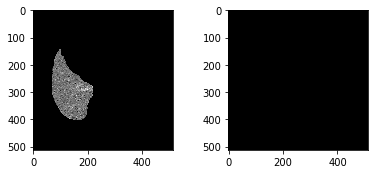

In [114]:
r = random.randint(0, len(x)-1)
# r=2
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
print(r)
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")

In [121]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [122]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [123]:
model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"], sample_weight_mode='temporal')
# model.summary()

In [143]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

model.fit(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, 
                    epochs=epochs)

Epoch 1/351
 16/351 [>.............................] - ETA: 54s - loss: 0.0308 - acc: 0.9981

StopIteration: [Errno 2] No such file or directory: 'train/masks/1.8_livertumor03/1.8_image_144_aug'

In [41]:
# model.save('tumor_cnn.h5')  # creates a HDF5 file 'my_model.h5'

model = keras.models.load_model('tumor_cnn.h5')
model.summary()

## del model

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 256, 256, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

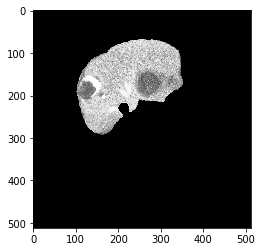

In [45]:
x, y = valid_gen.__getitem__(17)

result = model.predict(x)

result = result > 0.5

imshow(x[1])


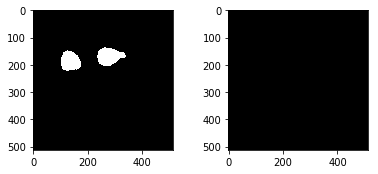

In [46]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[1]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[1]*255, (image_size, image_size)), cmap="gray")